In [2]:
!rm -rf InkubaLM-Challenge
!git clone https://github.com/melissafasol/InkubaLM-Challenge.git
%cd InkubaLM-Challenge


Cloning into 'InkubaLM-Challenge'...
remote: Enumerating objects: 513, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 513 (delta 65), reused 57 (delta 25), pack-reused 409 (from 1)
Receiving objects: 100% (513/513), 1.50 MiB | 3.77 MiB/s, done.
Resolving deltas: 100% (339/339), done.
/content/InkubaLM-Challenge


In [3]:
%cd InkubaLM-Challenge
!git pull


[Errno 2] No such file or directory: 'InkubaLM-Challenge'
/content/InkubaLM-Challenge
Already up to date.


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
!pip install -U trl bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
!pip install datasets

In [7]:
import sys
from pathlib import Path


import os
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from datasets import (
    load_dataset,
    concatenate_datasets,
    Dataset,
    Value
)
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)
from peft import (
    LoraConfig,
    get_peft_model,
    PeftModel
)
from trl import (
    SFTConfig,
    SFTTrainer,
    DataCollatorForCompletionOnlyLM
)

from utils import (
    eval,
    model_function,
    supplement,
    multitask,
    ab_testing
)


In [9]:
from google.colab import drive
drive.mount('/content/drive')
output_path = "/content/drive/MyDrive/InkubaLM-Challenge/Output"
os.makedirs(output_path, exist_ok=True)

Mounted at /content/drive


In [13]:
from huggingface_hub import login

try:
    from google.colab import userdata
    os.environ["hf_token_2"] = userdata.get("hf_token_2")
except:
    os.environ["hf_token_2"] = "----"

login(token=os.environ["hf_token_2"])

token = os.environ["hf_token_2"]
if token == "----":
    print("⚠️ Warning: No Hugging Face token found. Some models may not load.")
else:
    login(token=token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [11]:
hf_token_2 = '..'
os.environ["HF_TOKEN"] = hf_token_2

## **Load and Explore Datasets**

In [12]:
print("# Loading datasets")
se_dataset, mt_dataset,xn_dataset = multitask.load_and_combine_datasets("Train")
test_dataset = multitask.load_and_combine_datasets("Test")


# Loading datasets


README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/39.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/72.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/600 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/35.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

All Columns: ['targets', 'task', 'instruction', 'premise', 'langs', 'inputs', 'ID', 'data_source']


Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/600 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/486 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/33.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/484 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

All Columns: ['targets', 'task', 'instruction', 'premise', 'langs', 'inputs', 'ID', 'data_source']


Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

In [14]:
se_df = pd.DataFrame(se_dataset)
mt_df = pd.DataFrame(mt_dataset)
xn_df = pd.DataFrame(xn_dataset)

hau_se_df = se_df.loc[se_df['langs'] == 'hausa']
swa_se_df = se_df.loc[se_df['langs'] == 'swahili']

hau_xnli_df = xn_df.loc[xn_df['langs'] == 'hau']
swa_xnli_df = xn_df.loc[xn_df['langs'] == 'swa']

In [15]:
print(hau_se_df['targets'].value_counts())
print(swa_se_df['targets'].value_counts())

targets
Korau          72
Tsaka-tsaki    67
Kyakkyawa      61
Name: count, dtype: int64
targets
Wastani    124
Chanya      48
Hasi        28
Name: count, dtype: int64


# **Data Augmentation**

###**Problem:** sentiment analysis classes are heavily skewed towards neutral class for Swahili.

### **Solution**: supplement dataset with various augmentation techniques:
- **synonym replacement**
- **random swap**
- **random deletion** (produces data that is more similar to social media posts)

In [16]:
xn_df['task'] = 'afrixnli'
mt_df['task'] = 'mt'

In [17]:
df = se_df
df["is_augmented"] = False


augmented_rows = []
for _, row in df.iterrows():
    aug = supplement.apply_augmentation(row, supplement.synonyms_sent, lang_key_map = supplement.lang_map_sent)
    if aug is not None:
        augmented_rows.append(aug)

augmented_df = pd.DataFrame(augmented_rows)

sent_aug_df = pd.concat([se_df, augmented_df], ignore_index=True)

In [18]:
df = xn_df
df["is_augmented"] = False


augmented_rows = []
for _, row in df.iterrows():
    aug = supplement.apply_augmentation(row, supplement.synonyms_xnli, lang_key_map = supplement.lang_map_sent)
    if aug is not None:
        augmented_rows.append(aug)

augmented_df = pd.DataFrame(augmented_rows)

xnli_aug_df = pd.concat([xn_df, augmented_df], ignore_index=True)

In [19]:
train_df_concat = pd.concat([xnli_aug_df, sent_aug_df, mt_df], axis=0)
train_df_concat = train_df_concat.drop(columns=["is_augmented"], errors="ignore")

In [20]:
train_df_concat.head()

,ID,langs,premise,inputs,instruction,targets,task,data_source
0,ID_648d37ff_dev_afrixnli_hau,hau,"Kuma kawai sai naji Hakane, wannan din ne.","Bayan nace e, ya ƙare.","Is the following question True, False or Neither?",0,afrixnli,
1,ID_f96a39cb_dev_afrixnli_hau,hau,"Eh, Eh, na sani, ba zan ma damu sosai ba idan ...",Ba zan damu ba idan ɗaukan nauyin kuɗin da ake...,"Is the following question True, False or Neither?",0,afrixnli,
2,ID_4c5d953b_dev_afrixnli_swa,swa,"Alafu, hakuelewa kabisa.","Alas, hakuweza kuelewa wazi kutokana na kizuiz...","Is the following question True, False or Neither?",1,afrixnli,
3,ID_99a61e3d_dev_afrixnli_hau,hau,"Kuma kawai sai naji Hakane, wannan din ne.",Nace a'a amma yaci gaba da ja-in-ja.,"Is the following question True, False or Neither?",2,afrixnli,
4,ID_a38aa9d8_dev_afrixnli_swa,swa,Lakini siamini chombo chochote cha algorithmic...,Kanuni haziwezi kuamua jinsi ya kutengeneza mk...,"Is the following question True, False or Neither?",1,afrixnli,


In [21]:
print("\n# Applying target length balancing fix")
balanced_df = multitask.balance_target_lengths(train_df_concat)

print("\n# Analyzing target sequence lengths after balancing")
task_stats_after = multitask.analyze_task_lengths(balanced_df)



# Applying target length balancing fix

# Analyzing target sequence lengths after balancing
Target sequence length analysis by task:
Task: afrixnli
count    629.0
mean      11.0
std        0.0
min       11.0
25%       11.0
50%       11.0
75%       11.0
max       11.0
Name: targets, dtype: float64
--------------------------------------------------
Task: sentiment
count    623.0
mean      11.0
std        0.0
min       11.0
25%       11.0
50%       11.0
75%       11.0
max       11.0
Name: targets, dtype: float64
--------------------------------------------------
Task: mt
count    600.000000
mean      11.801667
std        8.347163
min        2.000000
25%        6.000000
50%       10.000000
75%       15.000000
max       62.000000
Name: targets, dtype: float64
--------------------------------------------------


# **Balance Target Token Lengths**

The Lelapa AI Buzuzu-Mavi Challenge is a multitask learning problem because the model needs to be able to do sentiment analysis, natural language inference (XNLI) and machine translation.


If the target token lengths are not balanced, this will cause the model to **over-prioritise** longer tasks.


### **How can you fix this?**
- **Repeating short targets**: (e.g., "positive" → "positive positive positive...") to match the average target lenght of the reference task (in this case it is translation)
- This ensures that **all tasks contribute more equally** to the total training loss and the **model doesn't ignore short-output tasks** like classification.


In [22]:
print("\n# Applying target length balancing fix")
balanced_df = multitask.balance_target_lengths(train_df_concat)


# Applying target length balancing fix


In [25]:
balanced_dataset = Dataset.from_pandas(balanced_df.reset_index(drop=True))

In [23]:
model_name = "lelapa/InkubaLM-0.4B"
model, tokenizer, bnb_config = multitask.setup_model_and_tokenizer(model_name, token=token,use_4bit=False)

config.json:   0%|          | 0.00/763 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/960 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/991k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.95M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

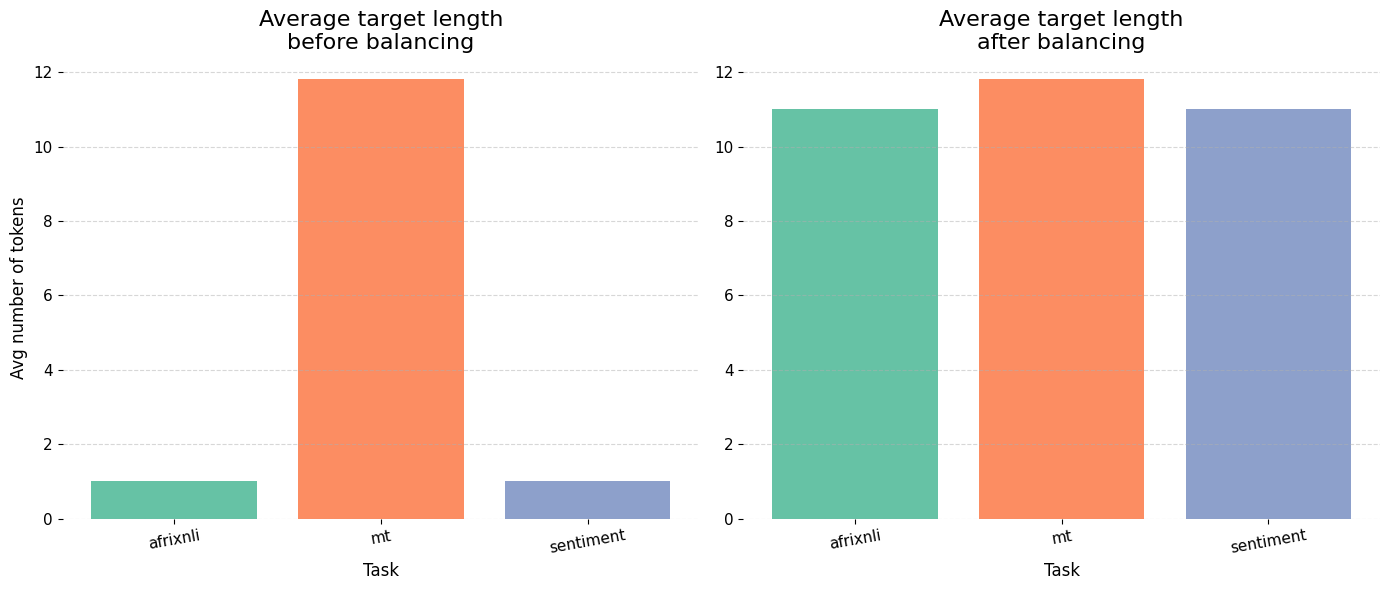

In [27]:
multitask.plot_target_lengths(train_df_concat, balanced_df)

In [118]:
balanced_trainer = multitask.setup_trainer(
    model=model,
    dataset=balanced_dataset,
    tokenizer=tokenizer,
    output_dir="./sft_model/balanced_heur_aug"
)
balanced_trainer.train()

Applying formatting function to train dataset:   0%|          | 0/1876 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/1876 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1876 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1876 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1876 [00:00<?, ? examples/s]

Step,Training Loss
10,1.226200
20,1.415800
30,1.214500
40,1.652200
50,1.345500
60,1.311500
70,1.697000
80,1.195300
90,1.338000
100,1.380700


TrainOutput(global_step=351, training_loss=0.8384678409649775, metrics={'train_runtime': 997.3634, 'train_samples_per_second': 5.643, 'train_steps_per_second': 0.352, 'total_flos': 2352865562910720.0, 'train_loss': 0.8384678409649775})

In [119]:
output_dir = '/content/drive/MyDrive/InkubaLM/outputs/'

In [120]:
model.save_pretrained(os.path.join(output_dir, "sft_model/balanced/lora_adapter_v3"))
tokenizer.save_pretrained(os.path.join(output_dir, "sft_model/balanced/lora_adapter_v3"))


('/content/drive/MyDrive/InkubaLM/outputs/sft_model/balanced/lora_adapter_v3/tokenizer_config.json',
 '/content/drive/MyDrive/InkubaLM/outputs/sft_model/balanced/lora_adapter_v3/special_tokens_map.json',
 '/content/drive/MyDrive/InkubaLM/outputs/sft_model/balanced/lora_adapter_v3/tokenizer.model',
 '/content/drive/MyDrive/InkubaLM/outputs/sft_model/balanced/lora_adapter_v3/added_tokens.json',
 '/content/drive/MyDrive/InkubaLM/outputs/sft_model/balanced/lora_adapter_v3/tokenizer.json')

In [128]:
from datasets import concatenate_datasets

# Combine the tuple into a list
test_dataset_list = list(test_dataset)

# Concatenate all the datasets into one
combined_test_dataset = concatenate_datasets(test_dataset_list)

In [129]:
combined_test_dataset

Dataset({
    features: ['ID', 'task', 'langs', 'data_source', 'instruction', 'inputs', 'targets', 'premise'],
    num_rows: 900
})

In [130]:
v2_path = os.path.join(output_dir, "sft_model/balanced_supp/checkpoint-351")
os.makedirs(v2_path, exist_ok=True)
inference_model = model.eval()
results_df = multitask.apply_inference_to_test_data(inference_model, tokenizer, combined_test_dataset)


Generating Responses:   0%|          | 0/900 [00:00<?, ?it/s]

In [131]:
results_df[['ID', 'Response']].to_csv(os.path.join(v2_path,'submission_full_finetune_v3.csv'), index=False)
results_df[['ID', 'generated','Response']].head()

,ID,generated,Response
0,ID_f3c74c7b_sentiment_test__hausa,Korau Korau Korau Korau Korau Korau Kora,2
1,ID_aad19dbf_sentiment_test__hausa,Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa,0
2,ID_f6de0381_sentiment_test__hausa,Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki,1
3,ID_cbec84fe_sentiment_test__swahili,Chanya Chanya Chanya Chanya Chanya Chanya Chan...,0
4,ID_885caf5c_sentiment_test__hausa,Korau Korau Korau Korau Korau Korau Kora,2


In [132]:
submission_csv = results_df[['ID','Response']]

In [43]:
submission_csv.to_csv(os.path.join(v2_path,'submission_full_finetune_v3.csv'), index=False)